In [1]:
%load_ext autoreload
%autoreload 2

from nb_002 import *

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'

train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test', train_ds.classes)

x = train_ds[1][0]

# Transform pipeline

## CIFAR augmentation

In [3]:
list(TfmType)

[<TfmType.Affine: 1>,
 <TfmType.Coord: 2>,
 <TfmType.Pixel: 3>,
 <TfmType.Lighting: 4>]

In [4]:
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Pixel:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform):
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)
    return x[:, row:row+rows, col:col+cols]

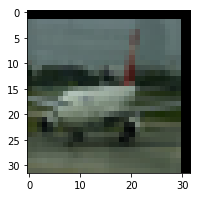

In [5]:
show_image(crop(pad(x, 4, 'constant'), 32, 0.25, 0.75), hide_axis=False)

In [7]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4, mode='constant'),
        crop_tfm(size=32)]

In [11]:
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable]
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        return apply_tfms(tfms)(x),y

In [12]:
train_tds = TfmDataset(train_ds, tfms)

KeyError: 'return'

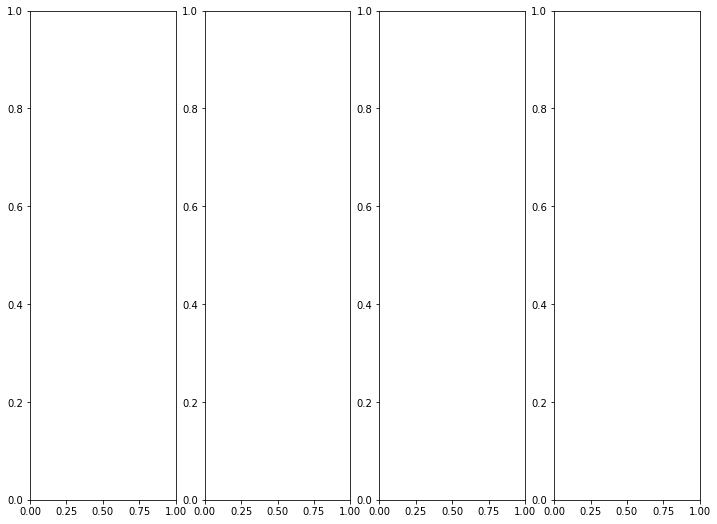

In [13]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(train_tds[1][0], ax)

## CIFAR training

In [17]:
data_mean = torch.tensor([0.49, 0.48, 0.45]).to(default_device)
data_std = torch.tensor([0.25, 0.24, 0.26]).to(default_device)

In [18]:
batch_transforms = xy_transforms([partial(normalize, data_mean, data_std)])

In [19]:
bs=64

In [20]:
data = DataBunch(train_tds, valid_ds, bs=bs, train_tfms=batch_transforms, valid_tfms=batch_transforms)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [21]:
x_,y_ = next(iter(data.train_dl))
x_ = denormalize(data_mean, data_std, x_).clamp(0,1.)

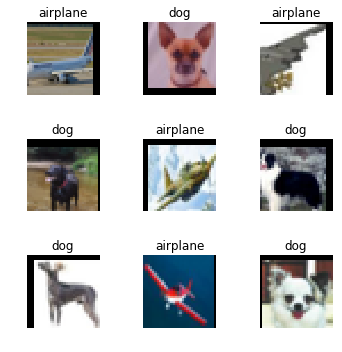

In [22]:
show_images(x_,y_,3,train_ds.classes, figsize=(5,5))

In [27]:
learn = Learner(data, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [28]:
opt_fn = partial(optim.SGD, momentum=0.9)

In [30]:
learn.fit(2, 0.1, opt_fn)

0 0.2471585681438446


1 0.22548777282238006



# Carvana

In [3]:
PATH = Path('data/carvana')
PATH_PNG = PATH/'train_masks_png'
PATH_X = PATH/'train-128'
PATH_Y = PATH/'train_masks-128'

## Convert and resize data

In [ ]:
PATH_PNG.mkdir(exist_ok=True)
PATH_X.mkdir(exist_ok=True)
PATH_Y.mkdir(exist_ok=True)

In [ ]:
def convert_img(fn): Image.open(fn).save(PATH_PNG/f'{fn.name[:-4]}.png')

In [ ]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [ ]:
def resize_img(fn, dirname):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/dirname/fn.name)

In [ ]:
files = list(PATH_PNG).iterdir())
with ThreadPoolExecutor(8) as e: e.map(partial(resize_img, dirname='train_masks-128'), files)

In [ ]:
files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(partial(resize_img, dirname='train-128'), files)

## Basic transforms

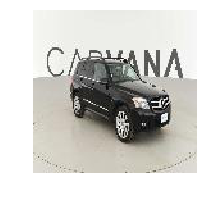

In [4]:
img_f = next(PATH_X.iterdir())
img_x = open_image(img_f)
show_image(img_x)

In [17]:
def get_y_fn(x_fn): return f'{x_fn[:-4]}_mask.png'

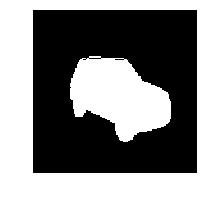

In [18]:
img_y_f = PATH_Y/get_y_fn(img_f.name)
img_y = open_image(img_y_f)
show_image(img_y)

In [6]:
def x(): return open_image(img_f)
def y(): return open_image(img_y_f)

In [26]:
tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-10,10.), p=0.25),
        zoom_tfm(scale=(0.8,1.2), p=0.25),
        contrast_tfm(scale=(0.8,1.2)),
        brightness_tfm(change=(0.4,0.6))
]

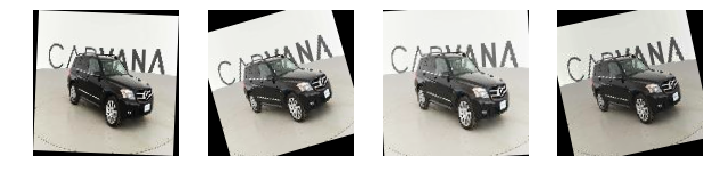

In [11]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_pipeline(x(), tfms), ax)

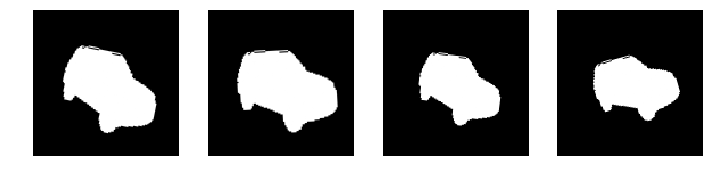

In [12]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_pipeline(y(), tfms), ax)

# Dependent var transforms

## Rotation

In [8]:
def xy(): return x(),y()

In [9]:
resolve_args(brightness, change=(0.4,0.6))

{'change': 0.4456196736709941}

In [10]:
def rotate_rand(x, y=None, smooth_y=True):
    args = resolve_args(rotate, degrees=(-45,45.))
    m = rotate(**args)
    x = do_affine(x, m)
    if y is None: return x
    
    y = do_affine(y, m)
    if not smooth_y: torch.round_(y)
    return x, y

In [13]:
imgx,imgy = rotate_rand(*xy(), smooth_y=False)
assert(torch.any((imgy>0.) & (imgy<1.)) == 0)

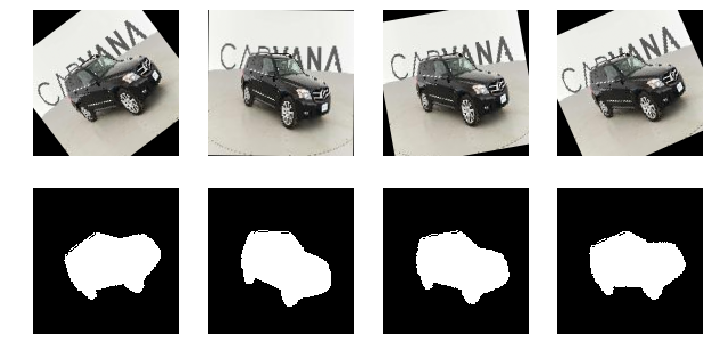

In [14]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    imgx,imgy = rotate_rand(*xy(), smooth_y=False)
    show_image(imgx, axes[0][i])
    show_image(imgy, axes[1][i])

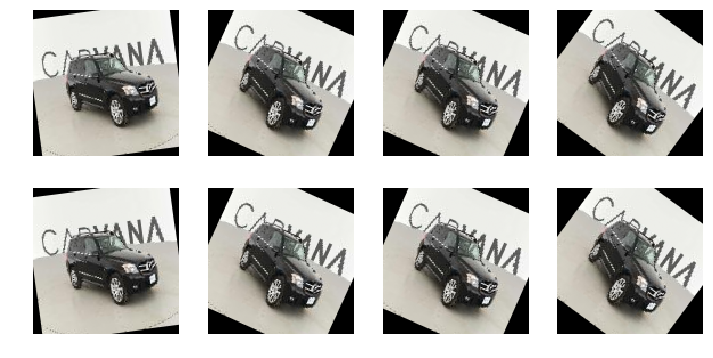

In [15]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    imgx,imgy = rotate_rand(x(),x())
    show_image(imgx, axes[0][i])
    show_image(imgy, axes[1][i])

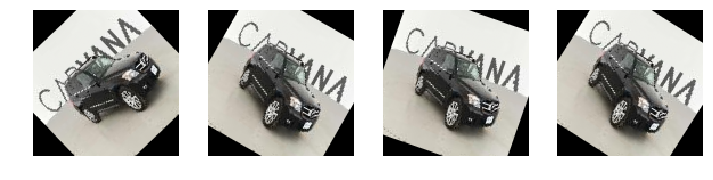

In [16]:
_,axes = plt.subplots(1,4, figsize=(12,6))
for ax in axes: show_image(rotate_rand(x()), ax)

## Affine transforms

In [11]:
def do_affine(img_x, img_y=None, m=None, funcs=None, smooth_y=True):
    if m is None: m=eye_new(img_x, 3)
    c = affine_grid(img_x,  img_x.new_tensor(m))
    c = compose(funcs)(c)
    img_x = grid_sample(img_x, c, padding='zeros')
    if img_y is None: return img_x

    img_y = grid_sample(img_y, c, padding='zeros')
    if not smooth_y: torch.round_(img_y)
    return img_x, img_y

In [12]:
def apply_pixel_tfm(func): 
    def _inner(x,y=None):
        logit_(x)
        if y is None: return func(x).sigmoid()
        logit_(y)
        x,y = func(x,y)
        return x.sigmoid(),y.sigmoid()
    
    return _inner

In [21]:
def apply_pipeline(tfms, x, y=None, smooth_y=True):
    tfms = listify(tfms)
    if len(tfms)==0: return x
    grouped_tfms = dict_groupby(tfms, lambda o: o.__annotations__['return'])
    pixel_tfms,coord_tfms,affine_tfms = map(grouped_tfms.get, TfmType)
    x = apply_pixel_tfm(compose(pixel_tfms))(x,y)
    if isinstance(x,tuple): x,y = x
    matrices = [f() for f in listify(affine_tfms)]
    return do_affine(x, y, affines_mat(x, matrices), funcs=coord_tfms, smooth_y=smooth_y)

In [22]:
tfms = [rotate_tfm(degrees=(-45,45.)), brightness_tfm(change=(0.3,0.7))]

In [29]:
imgx,imgy = apply_pipeline(tfms, *xy(), smooth_y=False)
assert(torch.any((imgy>0.) & (imgy<1.)) == 0)

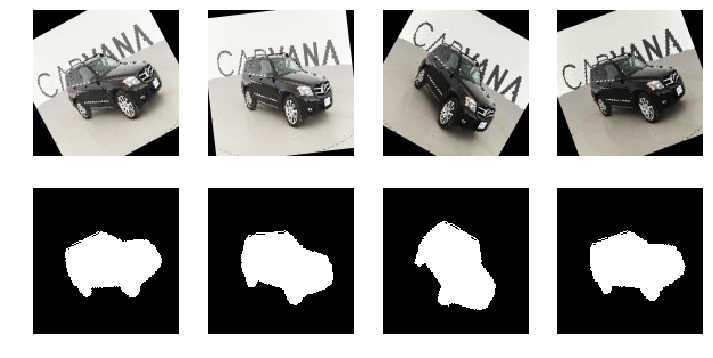

In [30]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    imgx,imgy = apply_pipeline(tfms, *xy(), smooth_y=False)
    show_image(imgx, axes[0][i])
    show_image(imgy, axes[1][i])

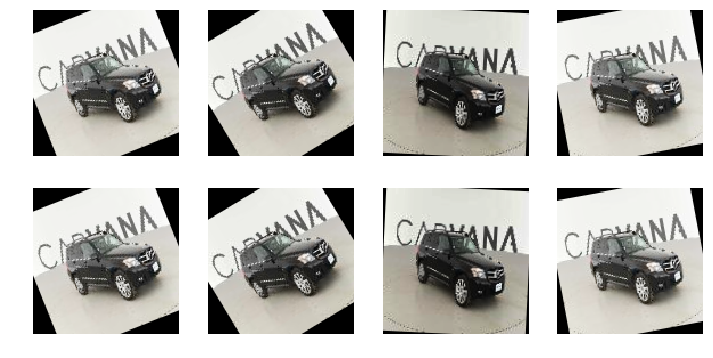

In [31]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    imgx,imgy = apply_pipeline(tfms, x(),x())
    show_image(imgx, axes[0][i])
    show_image(imgy, axes[1][i])

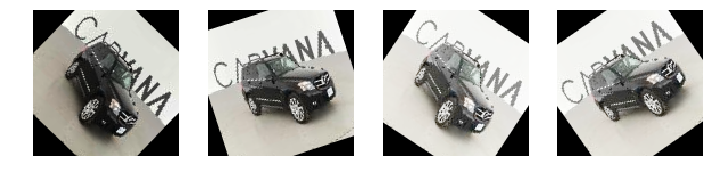

In [32]:
_,axes = plt.subplots(1,4, figsize=(12,6))
for ax in axes: show_image(apply_pipeline(tfms, x()), ax)

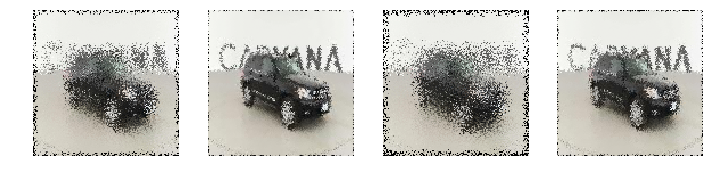

In [33]:
tfms2 = [jitter_tfm(magnitude=(-0.1,0.1))]

_,axes = plt.subplots(1,4, figsize=(12,6))
for ax in axes: show_image(apply_pipeline(tfms2, x()), ax)